In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9471 - acc: 0.3479
Epoch 00001: val_loss improved from inf to 2.45734, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_3_conv_checkpoint/001-2.4573.hdf5
36805/36805 [==============================] - 156s 4ms/sample - loss: 2.9472 - acc: 0.3479 - val_loss: 2.4573 - val_acc: 0.4230
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0840 - acc: 0.5232
Epoch 00002: val_loss did not improve from 2.45734
36805/36805 [==============================] - 150s 4ms/sample - loss: 2.0843 - acc: 0.5231 - val_loss: 2.5963 - val_acc: 0.4486
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7805 - acc: 0.6082
Epoch 00003: val_loss improved from 2.45734 to 2.18789, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_3_conv_checkpoint/003-2.1879.hdf5
36805/3680

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6897 - acc: 0.9324
Epoch 00029: val_loss did not improve from 2.18789
36805/36805 [==============================] - 149s 4ms/sample - loss: 0.6897 - acc: 0.9324 - val_loss: 2.8556 - val_acc: 0.6245
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6954 - acc: 0.9311
Epoch 00030: val_loss did not improve from 2.18789
36805/36805 [==============================] - 149s 4ms/sample - loss: 0.6958 - acc: 0.9310 - val_loss: 2.9910 - val_acc: 0.6152
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6891 - acc: 0.9325
Epoch 00031: val_loss did not improve from 2.18789
36805/36805 [==============================] - 149s 4ms/sample - loss: 0.6891 - acc: 0.9325 - val_loss: 3.0555 - val_acc: 0.6164
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6965 - acc: 0.9307
Epoch 00032: val_loss did not improve from 2.18789
36805/36805 [========

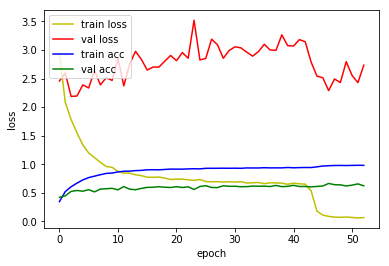

4815/4815 [==============================] - 9s 2ms/sample - loss: 2.3083 - acc: 0.4793
Loss: 2.308270645488212 Accuracy: 0.4793354

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1245 - acc: 0.3927
Epoch 00001: val_loss improved from inf to 1.40104, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_4_conv_checkpoint/001-1.4010.hdf5
36805/36805 [==============================] - 164s 4ms/sample - loss: 2.1244 - acc: 0.3927 - val_loss: 1.4010 - val_acc: 0.5791
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4225 - acc: 0.5751
Epoch 00002: val_loss improved from 1.40104 to 1.24511, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_4_conv_checkpoint/002-1.2451.hdf5
36805/36805 [==============================] - 161s 4ms/sample - loss: 1.4226 - acc: 0.5750 - val_loss: 1.2451 - val_acc: 0.6173
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1477 - acc: 0.9520
Epoch 00028: val_loss did not improve from 0.91374
36805/36805 [==============================] - 161s 4ms/sample - loss: 0.1478 - acc: 0.9520 - val_loss: 1.0868 - val_acc: 0.7706
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9499
Epoch 00029: val_loss did not improve from 0.91374
36805/36805 [==============================] - 161s 4ms/sample - loss: 0.1569 - acc: 0.9498 - val_loss: 1.2454 - val_acc: 0.7426
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1521 - acc: 0.9508
Epoch 00030: val_loss did not improve from 0.91374
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.1521 - acc: 0.9508 - val_loss: 1.1187 - val_acc: 0.7636
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1362 - acc: 0.9569
Epoch 00031: val_loss did not improve from 0.91374
36805/36805 [========


1D_CNN_custom_ch_128_DO_BN_4_conv Model


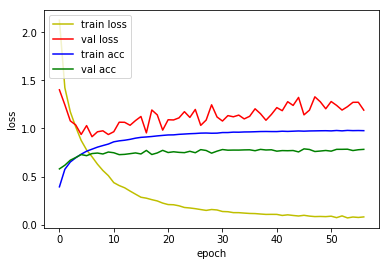

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.0380 - acc: 0.6993
Loss: 1.037950282366724 Accuracy: 0.6992731

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9655 - acc: 0.4276
Epoch 00001: val_loss improved from inf to 1.15920, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_5_conv_checkpoint/001-1.1592.hdf5
36805/36805 [==============================] - 173s 5ms/sample - loss: 1.9654 - acc: 0.4276 - val_loss: 1.1592 - val_acc: 0.6546
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2432 - acc: 0.6240
Epoch 00002: val_loss improved from 1.15920 to 0.97649, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_5_conv_checkpoint/002-0.9765.hdf5
36805/36805 [==============================] - 169s 5ms/sample - loss: 1.2433 - acc: 0.6240 - val_loss: 0.9765 - val_acc: 0.6958
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.1856 - acc: 0.9393
Epoch 00026: val_loss did not improve from 0.64792
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.1858 - acc: 0.9393 - val_loss: 0.6903 - val_acc: 0.8402
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1778 - acc: 0.9411
Epoch 00027: val_loss did not improve from 0.64792
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.1780 - acc: 0.9410 - val_loss: 0.9311 - val_acc: 0.7897
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1814 - acc: 0.9411
Epoch 00028: val_loss did not improve from 0.64792
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1814 - acc: 0.9411 - val_loss: 0.7098 - val_acc: 0.8316
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.9500
Epoch 00029: val_loss did not improve from 0.64792
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0725 - acc: 0.9773
Epoch 00056: val_loss did not improve from 0.64792
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0725 - acc: 0.9773 - val_loss: 0.7958 - val_acc: 0.8442
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0734 - acc: 0.9776
Epoch 00057: val_loss did not improve from 0.64792
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0734 - acc: 0.9776 - val_loss: 0.7434 - val_acc: 0.8502
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0781 - acc: 0.9758
Epoch 00058: val_loss did not improve from 0.64792
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0781 - acc: 0.9758 - val_loss: 0.8579 - val_acc: 0.8316
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0712 - acc: 0.9777
Epoch 00059: val_loss did not improve from 0.64792
36805/36805 [========

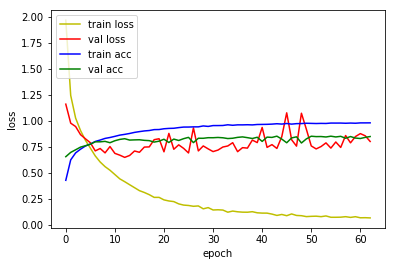

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.7460 - acc: 0.7919
Loss: 0.7460220728831622 Accuracy: 0.79190034

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9291 - acc: 0.4110
Epoch 00001: val_loss improved from inf to 1.05946, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_6_conv_checkpoint/001-1.0595.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 1.9292 - acc: 0.4109 - val_loss: 1.0595 - val_acc: 0.6893
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1581 - acc: 0.6403
Epoch 00002: val_loss improved from 1.05946 to 0.81392, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_6_conv_checkpoint/002-0.8139.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 1.1581 - acc: 0.6403 - val_loss: 0.8139 - val_acc: 0.7575
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1773 - acc: 0.9415
Epoch 00025: val_loss did not improve from 0.35976
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.1773 - acc: 0.9415 - val_loss: 0.4101 - val_acc: 0.9026
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1697 - acc: 0.9447
Epoch 00026: val_loss improved from 0.35976 to 0.35314, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_6_conv_checkpoint/026-0.3531.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.1697 - acc: 0.9447 - val_loss: 0.3531 - val_acc: 0.9099
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1636 - acc: 0.9482
Epoch 00027: val_loss did not improve from 0.35314
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.1636 - acc: 0.9482 - val_loss: 0.3664 - val_acc: 0.9175
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1574 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9779
Epoch 00054: val_loss did not improve from 0.35314
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0654 - acc: 0.9779 - val_loss: 0.4342 - val_acc: 0.9050
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9768
Epoch 00055: val_loss did not improve from 0.35314
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.0729 - acc: 0.9767 - val_loss: 0.3958 - val_acc: 0.9187
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0718 - acc: 0.9771
Epoch 00056: val_loss did not improve from 0.35314
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.0718 - acc: 0.9771 - val_loss: 0.3861 - val_acc: 0.9192
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9815
Epoch 00057: val_loss did not improve from 0.35314
36805/36805 [=====================

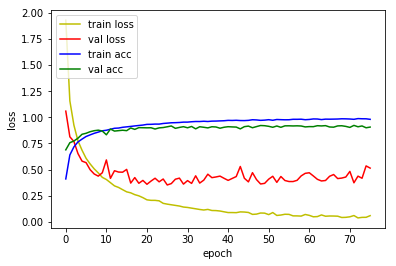

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.4125 - acc: 0.8891
Loss: 0.4124893016037787 Accuracy: 0.88909656

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9654 - acc: 0.4007
Epoch 00001: val_loss improved from inf to 1.13805, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_7_conv_checkpoint/001-1.1380.hdf5
36805/36805 [==============================] - 190s 5ms/sample - loss: 1.9654 - acc: 0.4007 - val_loss: 1.1380 - val_acc: 0.6478
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0680 - acc: 0.6664
Epoch 00002: val_loss improved from 1.13805 to 0.69274, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_7_conv_checkpoint/002-0.6927.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 1.0679 - acc: 0.6664 - val_loss: 0.6927 - val_acc: 0.8001
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1219 - acc: 0.9609
Epoch 00025: val_loss did not improve from 0.20060
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.1220 - acc: 0.9609 - val_loss: 0.2344 - val_acc: 0.9390
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9649
Epoch 00026: val_loss did not improve from 0.20060
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1079 - acc: 0.9649 - val_loss: 0.2077 - val_acc: 0.9474
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9683
Epoch 00027: val_loss did not improve from 0.20060
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0978 - acc: 0.9683 - val_loss: 0.2316 - val_acc: 0.9434
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9706
Epoch 00028: val_loss did not improve from 0.20060
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9845
Epoch 00054: val_loss did not improve from 0.19287
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0501 - acc: 0.9845 - val_loss: 0.1992 - val_acc: 0.9543
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9887
Epoch 00055: val_loss did not improve from 0.19287
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0370 - acc: 0.9887 - val_loss: 0.2148 - val_acc: 0.9518
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9899
Epoch 00056: val_loss did not improve from 0.19287
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0320 - acc: 0.9899 - val_loss: 0.2059 - val_acc: 0.9569
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9892
Epoch 00057: val_loss did not improve from 0.19287
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9920
Epoch 00083: val_loss did not improve from 0.19131
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0255 - acc: 0.9920 - val_loss: 0.2145 - val_acc: 0.9590
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9947
Epoch 00084: val_loss did not improve from 0.19131
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.0165 - acc: 0.9947 - val_loss: 0.2144 - val_acc: 0.9569
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9948
Epoch 00085: val_loss did not improve from 0.19131
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0173 - acc: 0.9948 - val_loss: 0.2349 - val_acc: 0.9518
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9941
Epoch 00086: val_loss did not improve from 0.19131
36805/36805 [=====================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9956
Epoch 00113: val_loss did not improve from 0.19131
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0150 - acc: 0.9956 - val_loss: 0.2291 - val_acc: 0.9585

1D_CNN_custom_ch_128_DO_BN_7_conv Model


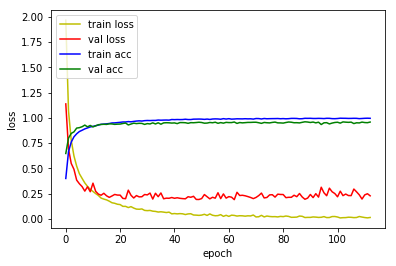

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2200 - acc: 0.9477
Loss: 0.21995471964125074 Accuracy: 0.94766355

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7818 - acc: 0.4594
Epoch 00001: val_loss improved from inf to 0.85323, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_8_conv_checkpoint/001-0.8532.hdf5
36805/36805 [==============================] - 193s 5ms/sample - loss: 1.7818 - acc: 0.4594 - val_loss: 0.8532 - val_acc: 0.7489
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8436 - acc: 0.7397
Epoch 00002: val_loss improved from 0.85323 to 0.45377, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_8_conv_checkpoint/002-0.4538.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.8438 - acc: 0.7397 - val_loss: 0.4538 - val_acc: 0.8749
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9807
Epoch 00026: val_loss did not improve from 0.12979
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0616 - acc: 0.9807 - val_loss: 0.1803 - val_acc: 0.9506
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0593 - acc: 0.9812
Epoch 00027: val_loss improved from 0.12979 to 0.12572, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_8_conv_checkpoint/027-0.1257.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0593 - acc: 0.9812 - val_loss: 0.1257 - val_acc: 0.9683
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9821
Epoch 00028: val_loss did not improve from 0.12572
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0557 - acc: 0.9821 - val_loss: 0.1695 - val_acc: 0.9588
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9949
Epoch 00055: val_loss did not improve from 0.11675
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0166 - acc: 0.9949 - val_loss: 0.1561 - val_acc: 0.9634
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9926
Epoch 00056: val_loss did not improve from 0.11675
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0235 - acc: 0.9926 - val_loss: 0.1954 - val_acc: 0.9525
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9900
Epoch 00057: val_loss did not improve from 0.11675
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0325 - acc: 0.9900 - val_loss: 0.1341 - val_acc: 0.9667
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9915
Epoch 00058: val_loss did not improve from 0.11675
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9937
Epoch 00085: val_loss did not improve from 0.11675
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0217 - acc: 0.9937 - val_loss: 0.1446 - val_acc: 0.9688
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9957
Epoch 00086: val_loss did not improve from 0.11675
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0155 - acc: 0.9956 - val_loss: 0.1955 - val_acc: 0.9639
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9950
Epoch 00087: val_loss did not improve from 0.11675
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.0157 - acc: 0.9949 - val_loss: 0.1566 - val_acc: 0.9665
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9966
Epoch 00088: val_loss did not improve from 0.11675
36805/36805 [========

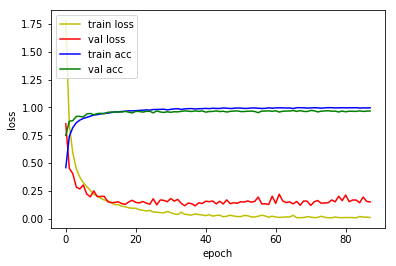

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.1543 - acc: 0.9585
Loss: 0.15429694436660746 Accuracy: 0.95846313

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3547 - acc: 0.5981
Epoch 00001: val_loss improved from inf to 0.43562, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_9_conv_checkpoint/001-0.4356.hdf5
36805/36805 [==============================] - 195s 5ms/sample - loss: 1.3547 - acc: 0.5980 - val_loss: 0.4356 - val_acc: 0.8710
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5306 - acc: 0.8347
Epoch 00002: val_loss improved from 0.43562 to 0.31164, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_BN_9_conv_checkpoint/002-0.3116.hdf5
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.5305 - acc: 0.8347 - val_loss: 0.3116 - val_acc: 0.9087
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9897
Epoch 00027: val_loss did not improve from 0.11160
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0325 - acc: 0.9896 - val_loss: 0.1461 - val_acc: 0.9634
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9890
Epoch 00028: val_loss did not improve from 0.11160
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0353 - acc: 0.9890 - val_loss: 0.1197 - val_acc: 0.9651
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9894
Epoch 00029: val_loss did not improve from 0.11160
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0341 - acc: 0.9894 - val_loss: 0.1397 - val_acc: 0.9632
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9926
Epoch 00030: val_loss did not improve from 0.11160
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9977
Epoch 00056: val_loss did not improve from 0.10050
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0081 - acc: 0.9977 - val_loss: 0.1225 - val_acc: 0.9730
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9982
Epoch 00057: val_loss did not improve from 0.10050
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0066 - acc: 0.9982 - val_loss: 0.1815 - val_acc: 0.9592
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9958
Epoch 00058: val_loss did not improve from 0.10050
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0142 - acc: 0.9958 - val_loss: 0.1215 - val_acc: 0.9704
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9945
Epoch 00059: val_loss did not improve from 0.10050
36805/36805 [=====================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9982
Epoch 00086: val_loss did not improve from 0.10050
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0061 - acc: 0.9982 - val_loss: 0.1376 - val_acc: 0.9720
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9978
Epoch 00087: val_loss did not improve from 0.10050
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0075 - acc: 0.9978 - val_loss: 0.1303 - val_acc: 0.9727
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9952
Epoch 00088: val_loss did not improve from 0.10050
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0166 - acc: 0.9952 - val_loss: 0.1496 - val_acc: 0.9690
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9988
Epoch 00089: val_loss did not improve from 0.10050
36805/36805 [========

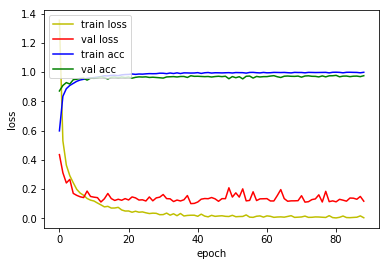

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.1336 - acc: 0.9628
Loss: 0.1335519655773016 Accuracy: 0.9628245



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           3805712     lambda[0][0]                     
                                                                 lam

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2200 - acc: 0.9477
Loss: 0.21995471964125074 Accuracy: 0.94766355

1D_CNN_custom_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequential)     

In [15]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           3805712     lambda[0][0]                     
                                                                 lam

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2589 - acc: 0.9443
Loss: 0.2589215408353017 Accuracy: 0.9443406

1D_CNN_custom_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (